# 1. Import Libraries

In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline

# 2. Environment Setup

#### 2.1 Define Products and Market Dynamics

In [20]:
# Define the products
products = {
    'Product A': {'cost': 30, 'base_price': 50},
    'Product B': {'cost': 20, 'base_price': 40},
    'Product C': {'cost': 50, 'base_price': 80},
    'Product D': {'cost': 15, 'base_price': 25},
    'Product E': {'cost': 100, 'base_price': 150},
}

# Define price ranges for each product
for product in products.keys():
    products[product]['min_price'] = products[product]['cost'] * 1.1  # Minimum price is 10% above cost
    products[product]['max_price'] = products[product]['base_price'] * 1.5  # Max price is 50% above base price

# Define market dynamics with price sensitivity
market_dynamics = {
    'Product A': {'max_demand': 500, 'price_sensitivity': 0.05, 'sigma': 20},
    'Product B': {'max_demand': 300, 'price_sensitivity': 0.04, 'sigma': 15},
    'Product C': {'max_demand': 200, 'price_sensitivity': 0.06, 'sigma': 10},
    'Product D': {'max_demand': 800, 'price_sensitivity': 0.03, 'sigma': 25},
    'Product E': {'max_demand': 100, 'price_sensitivity': 0.08, 'sigma': 5},
}

# Time periods (e.g., days)
time_periods = 365  # One year


#### 2.1 Simulate Customer Behavior

In [21]:
def calculate_demand(product, price):
    dynamics = market_dynamics[product]
    max_demand = dynamics['max_demand']
    price_sensitivity = dynamics['price_sensitivity']
    sigma = dynamics['sigma']

    # Exponential decay demand function
    base_demand = max_demand * np.exp(-price_sensitivity * price)
    random_fluctuation = np.random.normal(0, sigma)
    demand = base_demand + random_fluctuation
    demand = max(demand, 0)
    return demand


# 3. Reinforcement Learning Framework

#### 3.1 State, Action, and Reward Definitions

* **State** : A vector containing current prices for all products.
* **Action** : A vector of price adjustments for all products.
* **Reward** : Total profit across all products for the current time step.


# 4. Implement the Environment

In [22]:
class PricingEnvironment:
    def __init__(self, products, market_dynamics):
        self.products = products
        self.market_dynamics = market_dynamics
        self.reset()

    def reset(self):
        # Initialize prices to base prices
        self.current_prices = {p: info['base_price'] for p, info in self.products.items()}
        self.time_step = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        # State is the current prices of all products
        state = np.array(list(self.current_prices.values()), dtype=np.float32)
        return state

    def step(self, action):
        # Apply action (price adjustments)
        for idx, product in enumerate(self.products.keys()):
            self.current_prices[product] += action[idx]
            # Ensure prices are within bounds
            min_price = self.products[product]['min_price']
            max_price = self.products[product]['max_price']
            self.current_prices[product] = np.clip(self.current_prices[product], min_price, max_price)

        # Calculate reward (profit)
        total_profit = 0
        sales = {}
        for product in self.products.keys():
            price = self.current_prices[product]
            cost = self.products[product]['cost']
            demand = calculate_demand(product, price)
            profit = (price - cost) * demand
            total_profit += profit
            sales[product] = demand

        # Optional: Include penalty for low sales volume
        total_units_sold = sum(sales.values())
        expected_units_sold = sum([self.market_dynamics[p]['max_demand'] for p in self.products.keys()])
        penalty_factor = 0.1  # Adjust as needed
        total_profit -= penalty_factor * (expected_units_sold - total_units_sold)

        # Update time step
        self.time_step += 1
        if self.time_step >= time_periods:
            self.done = True

        # Get next state
        next_state = self._get_state()

        # Additional info for analysis
        info = {
            'profit': total_profit,
            'sales': sales,
            'prices': self.current_prices.copy()
        }

        return next_state, total_profit, self.done, info


# 5. Develop the RL Agent

We'll use a **Deep Q-Network (DQN)** with an experience replay buffer.

#### 5.1 Define the Neural Network

In [23]:
class DQNAgent(nn.Module):
    def __init__(self, state_size, num_products, num_actions_per_product, hidden_size=128):
        super(DQNAgent, self).__init__()
        self.num_products = num_products
        self.num_actions_per_product = num_actions_per_product
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, num_products * num_actions_per_product)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.out(x)


#### 5.1 Implement the Agent with Experience Replay

In [24]:
class Agent:
    def __init__(self, state_size, num_products, action_bins, gamma=0.99, lr=0.0001, batch_size=64, buffer_size=100000):
        self.state_size = state_size
        self.num_products = num_products
        self.action_bins = action_bins  # Indices of actions
        self.num_actions_per_product = len(action_bins)
        self.gamma = gamma
        self.lr = lr
        self.batch_size = batch_size
        self.buffer_size = buffer_size

        # Initialize networks
        self.policy_net = DQNAgent(state_size, num_products, self.num_actions_per_product)
        self.target_net = DQNAgent(state_size, num_products, self.num_actions_per_product)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        # Replay buffer
        self.memory = deque(maxlen=buffer_size)

        # Exploration parameters
        self.epsilon = 1.0  # Starting exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.998  # Make this dynamic based on performance if needed

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            # Explore: select random actions (indices)
            return np.random.choice(self.num_actions_per_product, size=self.num_products)
        else:
            # Exploit: select best action for each product
            state = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
            with torch.no_grad():
                q_values = self.policy_net(state)
            q_values = q_values.view(self.num_products, self.num_actions_per_product)
            _, indices = torch.max(q_values, dim=1)
            return indices.numpy()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return  # Not enough samples

        # Sample a batch
        minibatch = random.sample(self.memory, self.batch_size)
        state_batch = torch.FloatTensor([s[0] for s in minibatch])
        action_batch = torch.LongTensor([s[1] for s in minibatch])  # Shape: [batch_size, num_products]
        reward_batch = torch.FloatTensor([s[2] for s in minibatch])
        next_state_batch = torch.FloatTensor([s[3] for s in minibatch])
        done_batch = torch.FloatTensor([s[4] for s in minibatch])

        # Compute Q values
        q_values = self.policy_net(state_batch)  # Shape: [batch_size, num_products * num_actions_per_product]
        q_values = q_values.view(-1, self.num_products, self.num_actions_per_product)

        # Gather the Q-values for the actions taken
        action_batch = action_batch.unsqueeze(-1)  # Shape: [batch_size, num_products, 1]
        q_values = q_values.gather(2, action_batch).squeeze(-1)  # Shape: [batch_size, num_products]

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch)
            next_q_values = next_q_values.view(-1, self.num_products, self.num_actions_per_product)
            max_next_q_values, _ = next_q_values.max(dim=2)  # Shape: [batch_size, num_products]

        expected_q_values = reward_batch.unsqueeze(1) + (1 - done_batch.unsqueeze(1)) * self.gamma * max_next_q_values

        # Compute loss
        loss = F.mse_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Consider adjusting this decay based on learning progress or profit variance.

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())



# 6. Training the Agent

#### 6.1 Define Action Space

For each product, we'll allow price adjustments un discrete steps

In [25]:
# Define finer action bins for price adjustments
price_steps = [-2, -1, 0, 1, 2]  # Smaller adjustments
num_products = len(products)
action_size = num_products
action_bins = price_steps
state_size = num_products


#### 6.2 Training Loop

In [26]:
# Initialize environment and agent
env = PricingEnvironment(products, market_dynamics)
agent = Agent(state_size=state_size, num_products=num_products, action_bins=list(range(len(price_steps))))

# Training parameters
num_episodes = 500
target_update_freq = 10

# Tracking metrics
all_rewards = []
all_profits = []
all_epsilons = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    total_profit = 0
    while not env.done:
        # Select action indices
        action_indices = agent.select_action(state)  # Indices
        # Map indices to actual price adjustments
        action = [price_steps[idx] for idx in action_indices]

        # Take action in environment
        next_state, reward, done, info = env.step(action)

        # Remember experience
        agent.remember(state, action_indices, reward, next_state, done)

        # Replay and train
        agent.replay()

        # Update state
        state = next_state
        total_reward += reward
        total_profit += info['profit']

    # Update target network
    if episode % target_update_freq == 0:
        agent.update_target_network()

    # Logging
    all_rewards.append(total_reward)
    all_profits.append(total_profit)
    all_epsilons.append(agent.epsilon)
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode+1}/{num_episodes}, Total Profit: {total_profit:.2f}, Epsilon: {agent.epsilon:.2f}")


Episode 10/500, Total Profit: 2772705.59, Epsilon: 0.10
Episode 20/500, Total Profit: 2858417.01, Epsilon: 0.10
Episode 30/500, Total Profit: 2787920.01, Epsilon: 0.10
Episode 40/500, Total Profit: 2778091.03, Epsilon: 0.10
Episode 50/500, Total Profit: 2786935.76, Epsilon: 0.10
Episode 60/500, Total Profit: 2815317.11, Epsilon: 0.10
Episode 70/500, Total Profit: 2766686.70, Epsilon: 0.10
Episode 80/500, Total Profit: 2797354.91, Epsilon: 0.10
Episode 90/500, Total Profit: 2769594.51, Epsilon: 0.10
Episode 100/500, Total Profit: 2678476.52, Epsilon: 0.10
Episode 110/500, Total Profit: 2672203.96, Epsilon: 0.10
Episode 120/500, Total Profit: 2788552.39, Epsilon: 0.10
Episode 130/500, Total Profit: 2819337.23, Epsilon: 0.10
Episode 140/500, Total Profit: 2829090.68, Epsilon: 0.10
Episode 150/500, Total Profit: 2842750.19, Epsilon: 0.10
Episode 160/500, Total Profit: 2813293.33, Epsilon: 0.10
Episode 170/500, Total Profit: 2862544.25, Epsilon: 0.10
Episode 180/500, Total Profit: 2828583.1

In [27]:
# After training loop
torch.save(agent.policy_net.state_dict(), 'pricing_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [28]:
agent = Agent(state_size=state_size, num_products=num_products, action_bins=list(range(len(price_steps))))
agent.policy_net.load_state_dict(torch.load('pricing_model.pth'))
agent.policy_net.eval()
print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-28-eb520067f4b4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy_net.load_state_dict(torch.load('pricing_model.pth'))


# 7. Evaluation

#### 7.1 Plot Training Progress

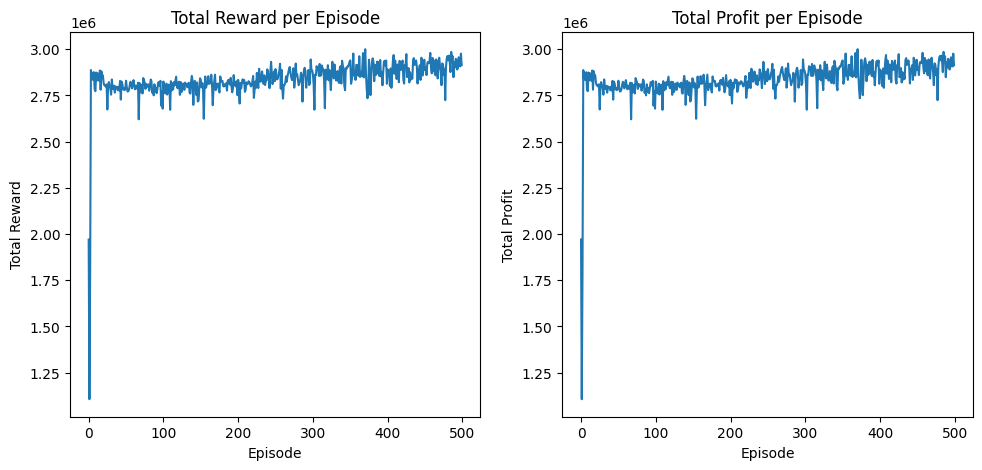

In [29]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(all_rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1,3,2)
plt.plot(all_profits)
plt.title('Total Profit per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Profit')

plt.show()


#### 7.2 Analyze Pricing Strategies

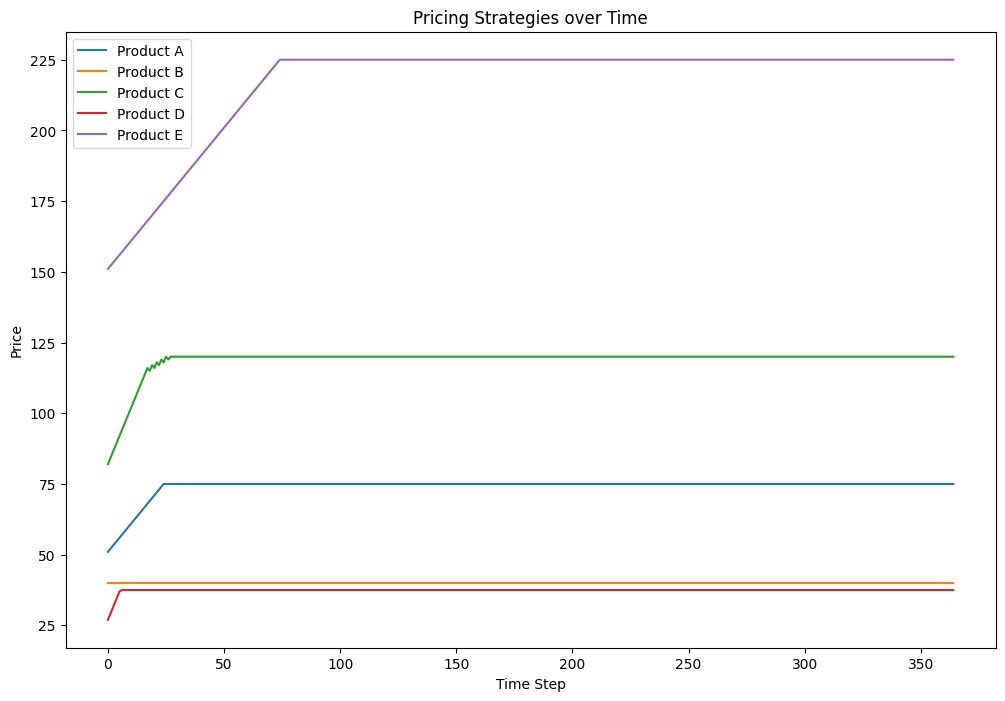

In [30]:
# Disable exploration
agent.epsilon = 0.0

# Reset environment
state = env.reset()
profits = []
prices_history = {p: [] for p in products.keys()}
sales_history = {p: [] for p in products.keys()}

while not env.done:
    # Select action
    action_indices = agent.select_action(state)
    action = [price_steps[idx] for idx in action_indices]

    # Take action in environment
    next_state, reward, done, info = env.step(action)

    # Update state
    state = next_state

    # Record data
    profits.append(info['profit'])
    for product in products.keys():
        prices_history[product].append(info['prices'][product])
        sales_history[product].append(info['sales'][product])

# Plot pricing strategies
plt.figure(figsize=(12,8))
for product in products.keys():
    plt.plot(prices_history[product], label=product)
plt.title('Pricing Strategies over Time')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()


#### 7.3 Compare Against Baseline Strategies

In [31]:
def baseline_strategy(env):
    state = env.reset()
    total_profit = 0
    sales_history_baseline = {p: [] for p in products.keys()}
    prices_history_baseline = {p: [] for p in products.keys()}
    while not env.done:
        action = [0] * num_products  # No price adjustments
        next_state, reward, done, info = env.step(action)
        total_profit += info['profit']
        for product in products.keys():
            sales_history_baseline[product].append(info['sales'][product])
            prices_history_baseline[product].append(info['prices'][product])
    return total_profit, sales_history_baseline, prices_history_baseline

# Run baseline strategy
baseline_profit, sales_history_baseline, prices_history_baseline = baseline_strategy(env)


In [32]:
rl_agent_profit = sum(profits)

print(f"Total Profit - RL Agent: ${rl_agent_profit:,.2f}")
print(f"Total Profit - Baseline Strategy: ${baseline_profit:,.2f}")
profit_improvement = ((rl_agent_profit - baseline_profit) / baseline_profit) * 100
print(f"Profit Improvement: {profit_improvement:.2f}%")


Total Profit - RL Agent: $2,965,824.25
Total Profit - Baseline Strategy: $2,150,151.85
Profit Improvement: 37.94%


In [33]:
average_daily_profit_rl = rl_agent_profit / time_periods
average_daily_profit_baseline = baseline_profit / time_periods
print(f"Average Daily Profit - RL Agent: ${average_daily_profit_rl:,.2f}")
print(f"Average Daily Profit - Baseline Strategy: ${average_daily_profit_baseline:,.2f}")


Average Daily Profit - RL Agent: $8,125.55
Average Daily Profit - Baseline Strategy: $5,890.83


In [34]:
# Calculate total units sold for each product
total_units_sold_rl = {product: sum(sales_history[product]) for product in products.keys()}
total_units_sold_baseline = {product: sum(sales_history_baseline[product]) for product in products.keys()}

# Create a DataFrame for comparison
sales_comparison = pd.DataFrame({
    'Product': products.keys(),
    'Units Sold (RL Agent)': total_units_sold_rl.values(),
    'Units Sold (Baseline)': total_units_sold_baseline.values()
})

sales_comparison


,Product,Units Sold (RL Agent),Units Sold (Baseline)
0,Product A,5883.445400,14499.114305
1,Product B,22544.493601,22086.232911
2,Product C,1528.633765,1914.494417
3,Product D,95125.874414,137561.066642
4,Product E,676.439844,741.383463


In [35]:
# Calculate average selling price for each product
average_price_rl = {product: np.mean(prices_history[product]) for product in products.keys()}
average_price_baseline = {product: np.mean(prices_history_baseline[product]) for product in products.keys()}

# Create a DataFrame for comparison
price_comparison = pd.DataFrame({
    'Product': products.keys(),
    'Avg. Selling Price (RL Agent)': average_price_rl.values(),
    'Avg. Selling Price (Baseline)': average_price_baseline.values()
})

price_comparison


,Product,Avg. Selling Price (RL Agent),Avg. Selling Price (Baseline)
0,Product A,74.178082,50.0
1,Product B,40.000000,40.0
2,Product C,118.906849,80.0
3,Product D,37.409589,25.0
4,Product E,217.397260,150.0


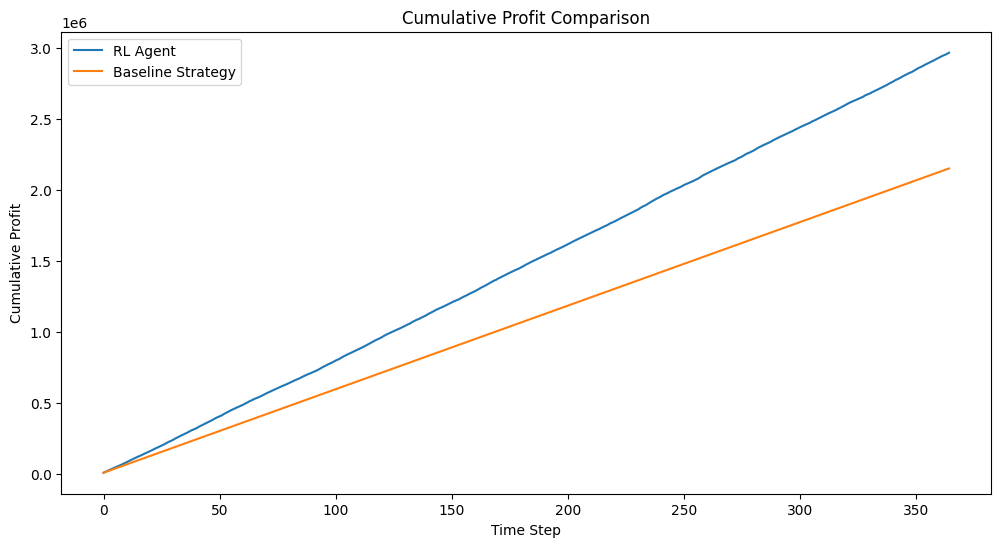

In [36]:
# Plot profit comparison
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(profits), label='RL Agent')
plt.plot(np.cumsum([baseline_profit/time_periods]*time_periods), label='Baseline Strategy')
plt.title('Cumulative Profit Comparison')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.show()
